In [1]:
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt

In [2]:
def discretize(state, bins):
    state_bins = [np.digitize(state[i], bins[i]) - 1 for i in range(len(state))]
    state_bins = [max(0, min(len(bins[i])-1, state_bins[i])) for i in range(len(state_bins))]
    return tuple(state_bins)

In [3]:
def create_bins(num_bins):
    position_bins = np.linspace(-1.2, 0.6, num_bins)
    velocity_bins = np.linspace(-0.07, 0.07, num_bins)
    return [position_bins, velocity_bins]


In [4]:
def initialize_q_table(num_bins, num_actions):
    return np.zeros([num_bins, num_bins, num_actions])

In [5]:
def policy_evaluation(env, q_table, policy, bins, gamma, theta):
    while True:
        delta = 0
        for pos in range(len(bins[0])):
            for vel in range(len(bins[1])):
                state = (pos, vel)
                old_value = q_table[state + (policy[state],)]
                new_value = 0
                env.reset()
                env.unwrapped.state = (bins[0][pos], bins[1][vel])  # Set to the discrete state
                action = policy[state]
                next_state, reward, terminated, truncated, _ = env.step(action)
                next_state = discretize(next_state, bins)
                done = terminated or truncated
                new_value += reward + gamma * np.max(q_table[next_state]) * (not done)
                q_table[state + (policy[state],)] = new_value
                delta = max(delta, np.abs(old_value - new_value))
        if delta < theta:
            break


In [6]:
def policy_improvement(q_table, policy, bins):
    policy_stable = True
    for pos in range(len(bins[0])):
        for vel in range(len(bins[1])):
            state = (pos, vel)
            old_action = policy[state]
            policy[state] = np.argmax(q_table[state])
            if old_action != policy[state]:
                policy_stable = False
    return policy_stable

In [7]:
def policy_iteration(env, q_table, bins, gamma, theta, episodes):
    policy = {}
    for pos in range(len(bins[0])):
        for vel in range(len(bins[1])):
            policy[(pos, vel)] = np.random.choice(env.action_space.n)

    rewards = []
    for episode in range(episodes):
        policy_evaluation(env, q_table, policy, bins, gamma, theta)
        policy_stable = policy_improvement(q_table, policy, bins)

        state = discretize(env.reset()[0], bins)
        total_reward = 0
        done = False
        while not done:
            action = policy[state]
            new_state, reward, terminated, truncated, _ = env.step(action)
            new_state = discretize(new_state, bins)
            done = terminated or truncated
            state = new_state
            total_reward += reward

        rewards.append(total_reward)
        if policy_stable:
            break

    return rewards, q_table, policy

In [8]:
def plot_results(rewards, granularity, parameter, value, filename):
    plt.figure()
    plt.plot(range(len(rewards)), rewards, label=f'Granularity: {granularity}, {parameter}: {value}')
    plt.xlabel('Episodes')
    plt.ylabel('Total Reward')
    plt.title(f'Reward vs Episodes ({parameter}: {value})')
    plt.legend()
    plt.savefig(filename)
    plt.close()

In [9]:
# Grid map of policy
def plot_policy(policy, bins, filename):
    policy_grid = np.zeros((len(bins[0]), len(bins[1])))
    for pos in range(len(bins[0])):
        for vel in range(len(bins[1])):
            policy_grid[pos, vel] = policy[(pos, vel)]
    plt.figure()
    plt.imshow(policy_grid, origin='lower', cmap='viridis')
    plt.colorbar(ticks=[0, 1, 2], label='Action')
    plt.title('Policy Grid')
    plt.xlabel('Position')
    plt.ylabel('Velocity')
    plt.savefig(filename)
    plt.close()

In [10]:
env = gym.make('MountainCar-v0')
num_actions = env.action_space.n
episodes = 5000
gamma = 0.99
theta = 0.0001  # Convergence threshold

granularities = [10, 20, 30, 40, 50]
parameter = 'learning_rate'
values = [0.1, 0.5, 0.9]

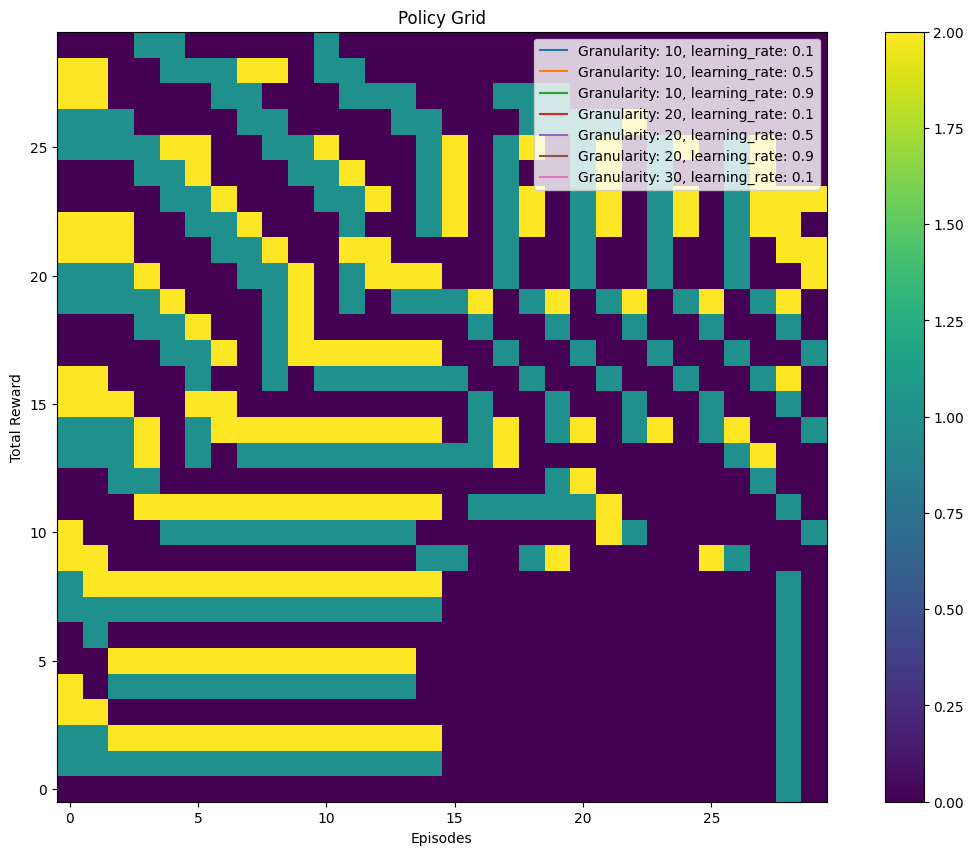

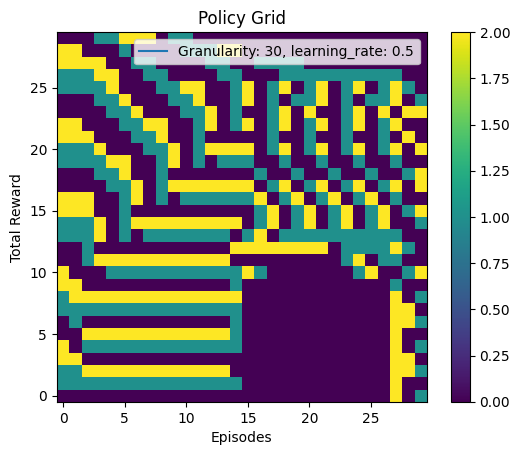

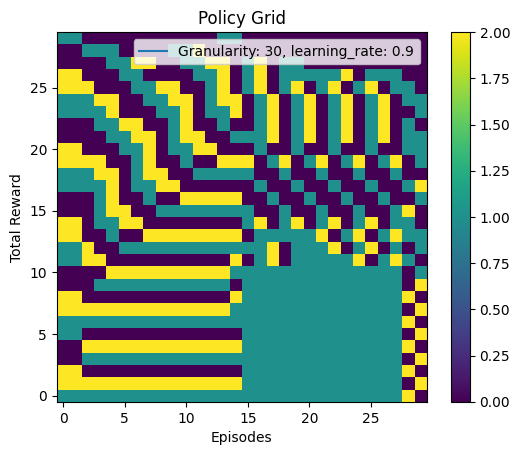

In [ ]:
for granularity in granularities:
    for value in values:
        bins = create_bins(granularity)
        q_table = initialize_q_table(granularity, num_actions)
        rewards, q_table, policy = policy_iteration(env, q_table, bins, gamma, theta, episodes)
        plot_results(rewards, granularity, parameter, value, f'rewards_granularity_{granularity}_lr_{value}.png')
        if granularity == 30:
            plot_policy(policy, bins, f'policy_grid_granularity_{granularity}_lr_{value}.png')

In [ ]:
for granularity in granularities:
    for value in values:
        bins = create_bins(granularity)
        q_table = initialize_q_table(granularity, num_actions)
        rewards, q_table, policy = policy_iteration(env, q_table, bins, gamma, theta, episodes)
        plot_results(rewards, granularity, parameter, value, f'rewards_granularity_{granularity}_lr_{value}.png')
        if granularity == 30:
            plot_policy(policy, bins, f'policy_grid_granularity_{granularity}_lr_{value}.png')

In [ ]:
# Save plots for effect of granularity
for granularity in granularities:
    bins = create_bins(granularity)
    q_table = initialize_q_table(granularity, num_actions)
    rewards, q_table, policy = policy_iteration(env, q_table, bins, gamma, theta, episodes)
    plot_results(rewards, granularity, parameter='learning_rate', value=0.5, filename=f'granularity_{granularity}.png')
    if granularity == 30:
        plot_policy(policy, bins, filename=f'policy_grid_{granularity}.png')

In [11]:
# Save plots for effect of learning rate
learning_rates = [0.1, 0.5, 0.9]
for learning_rate in learning_rates:
    bins = create_bins(30)  # Using granularity 30 as an example
    q_table = initialize_q_table(30, num_actions)
    rewards, q_table, policy = policy_iteration(env, q_table, bins, gamma, theta, episodes)
    plot_results(rewards, granularity=30, parameter='learning_rate', value=learning_rate, filename=f'learning_rate_{learning_rate}.png')
    if learning_rate == 0.5:
        plot_policy(policy, bins, filename=f'policy_grid_learning_rate_{learning_rate}.png')